In [33]:
from __future__ import division

from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

In [114]:
def find_indices(x, y):
    """
    Find the index of every element of y in x 
    """
    # indices that would sort x (length x)
    index = np.argsort(x)

    sorted_x = x[index]

    # index of every element of y in sorted x (length y)
    # can't plug this into either x or y: 
    # it's too short for x (being length y) and it's x's indices
    # which are too large for y
    sorted_index = np.searchsorted(sorted_x, y)

    # this returns the value of "index" at each index, "sorted_index"
    # so if sorted_index = [273404, 273405, ...]
    # you'll get the value in "index" at THOSE indices
    # since "index" is itself a list of indices, you're actually getting
    # "unsorted" indices in x that correspond to matching values in y
    # (length y) ; x[yindex] = matching values in y
    yindex = np.take(index, sorted_index)
    mask = x[yindex] != y

    result = np.ma.array(yindex, mask=mask)

    return result

In [115]:
# This is the aggregated table of expert classification after the panoptes run
experts = Table.read('expert_aggregated_votes.fits')

# This is a table of ALL volunteer votes aggregated together for the entire sample
# Specifically, using simulation "S_standard"
users = Table.read('aggregate_votes_total_S_standard.fits')

In [116]:
# The "users" table above is ordered by ascending asset_id (tho that column isn't present)
# but the expert table is not sorted... 
experts.sort('asset_id')

# Super. Now it is. 
print experts[:4]

expert_id asset_id majority_vote ...     ra        dec        Separation   
                                 ...                            arcsec     
--------- -------- ------------- ... ---------- --------- -----------------
  1520449       16             5 ... 184.535645 -1.064114  0.00185408690931
  1520621       49             5 ... 191.970779 -1.185845  0.00223818742806
  1520724       77             5 ... 196.773529 -1.176841 0.000951713739891
  1520772       96             5 ... 198.154114 -1.197509  0.00168601835102


In [117]:
# The votes in the "expert" table are already summed -- normalize them
norm_expert_vote = np.array(experts['majority_vote'],dtype='float64')\
                    /experts['classification_count']
    
# Another dumb thing I did when making that table was that Feat = 1, Smooth = 0
# Except, in EVERYTHING ELSE I DO, it's the other way around. 
# So. Flip these votes so they match user orientation. 
norm_expert_vote = 1 - norm_expert_vote

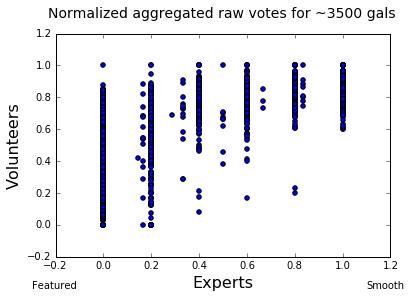

In [124]:
# Plot everything. 
plt.scatter(norm_expert_vote, users['norm_aggregate_votes'])
plt.xlabel('Experts',fontsize=16)
plt.ylabel('Volunteers',fontsize=16)

plt.text(-0.23, 1.3, 'Normalized aggregated raw votes for ~3500 gals',fontsize=14)
plt.text(1.1,-0.4, 'Smooth')
plt.text(-0.3, -0.4,'Featured')

In [125]:
# Went back through that simulation and pulled out the number of users
# that classified each galaxy, their skill level, and their vote
tt = Table.read('asset_user_skill_vote.fits')

In [126]:
# Group these by asset
grpd_by_asset = tt.group_by('asset_id')

In [127]:
# Here, I'm trying to isolate the 5 (because we had 5 experts per galaxy) 
# most highly skilled volunteers for each galaxy
# so we can compare them directly to the experts. 

norm_agg_user_vote = []

num_users,problem_assets,all_assets= [],[],[]
good_assets = []


i = 0

# Loop through each group 
for grp in grpd_by_asset.groups:
    
    # This sorts the group by user SKILL in ascending order 
    grp.sort('skill')
    
    # I just wanted an array of all the asset ids.. 
    all_assets.append(int(grp['asset_id'][0]))
    
    # Turns out not every asset was classifed 5 times by volunteers... 
    if len(grp) >= 5:
        # We want the 5 best users (take bottom 5 cuz skill is ascending order)
        best = grp[-5:]
        
        # get the normalized aggregate vote
        norm_agg_user_vote.append(sum(best['vote'])/5.)
        
        # keep track of which galaxies have at least 5 volunteers
        good_assets.append(int(grp['asset_id'][0]))
        
    #elif len(grp) >= 5 and len(grp) < 10:
    #    # We want the 5 best users (for now)
    #    secondbest = grp[-5:]
    #    norm_agg_user_vote.append(sum(secondbest['vote'])/5.)
    #    good_assets.append(int(grp['asset_id'][0]))  

    else:
        # If we don't have 5, just take the norm_agg vote for what we do have
        norm_agg_user_vote.append(sum(grp['vote'])/len(grp))
        num_users.append(len(grp))
        problem_assets.append(int(grp['asset_id'][0]))
        i+=1


In [74]:
# About 150 of the ~3500 had fewer than 5 volunteers -- find th
ind = find_indices(np.array(all_assets,dtype='int64'),
                   np.array(good_assets,dtype='int64'))    

norm_expert_trunc = np.array(norm_expert_vote)[ind]
norm_user_trunc = np.array(norm_agg_user_vote)[ind]

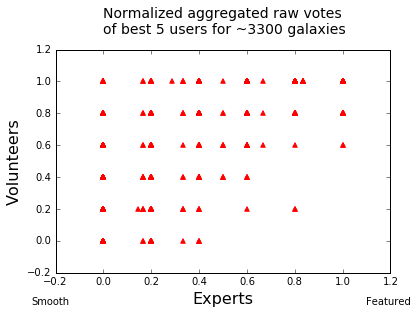

In [109]:
#plt.scatter(norm_expert_vote, norm_agg_user_vote)
plt.scatter(norm_expert_trunc, norm_user_trunc,color='r',marker='^')
plt.xlabel('Experts',fontsize=16)
plt.ylabel('Volunteers',fontsize=16)

plt.text(0., 1.4, 'Normalized aggregated raw votes ',fontsize=14)
plt.text(0., 1.3, 'of best 5 users for ~3300 galaxies',fontsize=14)
plt.text(1.1,-0.4, 'Featured')
plt.text(-0.3, -0.4,'Smooth')

plt.savefig('expert_vs_volunteer_votes_highskill.png')

In [99]:
metadata = Table.read('metadata_ground_truth_labels.fits')

In [104]:
print metadata[95]

<Row 95 of table
 values=(587722981748048006, 'J131236.98-011151.02', 96, 0, 0, 198.15411377, -1.197509408, 48.24446105957031, 3.269852876663208, 0.052690375596284866, 0.568808376789093, -2.1144251823425293, 0.22029131650924683, 0, 0, 40, 3.0, 'test', 0.3, 0, 0, 0, 'http://cas.sdss.org/dr7/en/tools/quicklook/quickobj.asp?id=587722981748048006')
 dtype=[('SDSS_id', '>i8'), ('JID', 'S20'), ('asset_id', '>i4'), ('stripe82', '>i2'), ('extra_original', '>i2'), ('ra', '>f8'), ('dec', '>f8'), ('Rp', '>f4'), ('C', '>f4'), ('A', '>f4'), ('G', '>f4'), ('M20', '>f4'), ('E', '>f4'), ('Rpflag', '>i4'), ('bflag', '>i4'), ('total_classifications', '>i2'), ('TType', '>f4'), ('MLsample', 'S5'), ('SWAP_prob', '>f8'), ('GZ2_label', '>i8'), ('Nair_label', '>i8'), ('Expert_label', '>i8'), ('external_ref', 'S77')]>
